## import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX


plt.rcParams['figure.figsize'] = (10, 5)
sns.set()

import warnings
warnings.filterwarnings("ignore")

## Dataset

In [2]:
earthquake = pd.read_csv('earthquakes.csv', parse_dates=True, index_col='date')
earthquake.drop(['Year'], axis = 1, inplace = True)
earthquake.head()

,earthquakes_per_year
date,
1900-01-01,13.0
1901-01-01,14.0
1902-01-01,8.0
1903-01-01,10.0
1904-01-01,16.0


In [3]:
earthquake.shape

(99, 1)

## Check stationarity

test statistic : -3.183192251191782
P-value : 0.02097842525600371


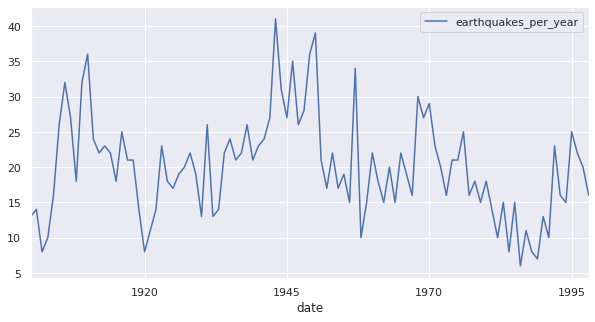

In [4]:
earthquake.plot()
result = adfuller(earthquake['earthquakes_per_year'])

print('test statistic :', result[0])
print('P-value :', result[1])

* test statistic for dataset is -3.18 (more negative,more likely to be stationary)
* P-value is 0.02 so we reject the null hypotesis (assume our time series must be stationar)

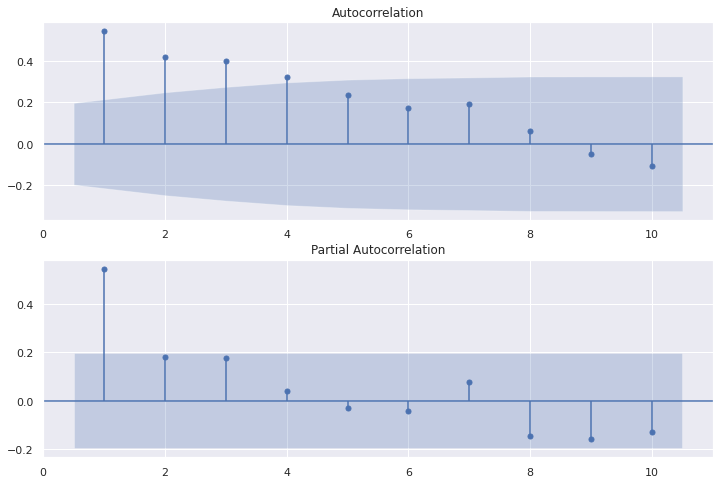

In [5]:
#plotting ACF & PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(earthquake, lags=10, zero=False, ax=ax1);
plot_pacf(earthquake, lags=10, zero=False, ax=ax2);

* ACF : tail off
* PACF : cut off after lag 1
so our model must be AR(1) or ARIMA(1,0,0)

## checking AIC & BIC

In [6]:
# estimation the best model
aic_bic = []
for p in range(3):
    for q in range(3):
        model = SARIMAX(earthquake, order = (p,0,q))
        results = model.fit()
        aic_bic.append((p, q, results.aic, results.bic))

#create dataframe
aic_bic_score = pd.DataFrame(aic_bic, columns = ['P', 'Q', 'AIC Score', 'BIC Score'])

In [7]:
print(aic_bic_score.sort_values('AIC Score'))

   P  Q   AIC Score   BIC Score
4  1  1  647.132300  654.917660
5  1  2  648.738566  659.119046
7  2  1  648.842840  659.223319
8  2  2  648.850644  661.826244
6  2  0  656.028374  663.813734
3  1  0  666.645526  671.835765
2  0  2  761.067479  768.852838
1  0  1  799.674173  804.864412
0  0  0  888.429772  891.024892


In [8]:
print(aic_bic_score.sort_values('BIC Score'))

   P  Q   AIC Score   BIC Score
4  1  1  647.132300  654.917660
5  1  2  648.738566  659.119046
7  2  1  648.842840  659.223319
8  2  2  648.850644  661.826244
6  2  0  656.028374  663.813734
3  1  0  666.645526  671.835765
2  0  2  761.067479  768.852838
1  0  1  799.674173  804.864412
0  0  0  888.429772  891.024892


                                SARIMAX Results                                 
Dep. Variable:     earthquakes_per_year   No. Observations:                   99
Model:                 SARIMAX(1, 0, 1)   Log Likelihood                -320.566
Date:                  Tue, 16 Nov 2021   AIC                            647.132
Time:                          12:23:51   BIC                            654.918
Sample:                      01-01-1900   HQIC                           650.282
                           - 01-01-1998                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9893      0.014     70.282      0.000       0.962       1.017
ma.L1         -0.5517      0.089     -6.198      0.000      -0.726      -0.377
sigma2        37.0254      4.980    

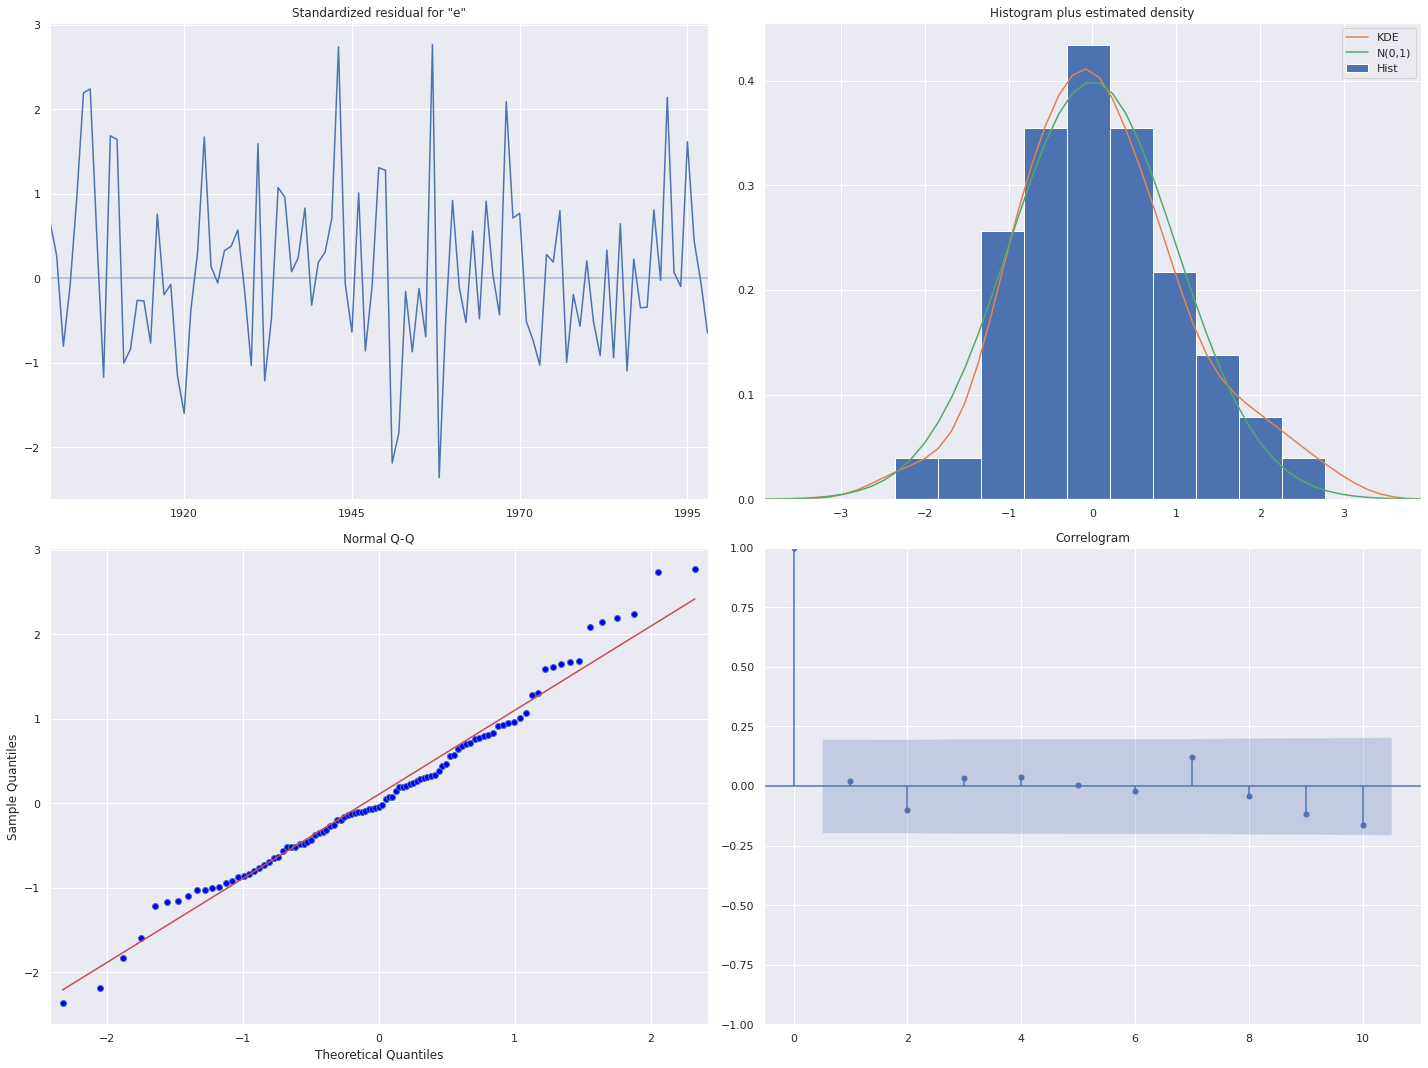

In [9]:
# Create and fit model
model = SARIMAX(earthquake, order=(1, 0, 1))
results = model.fit()

# Create the 4 diagnostics plots
results.plot_diagnostics(figsize=(20, 15));
plt.tight_layout()

# Print summary
print(results.summary())

## forecast for the next years

In [10]:
#get prediction for next 5 years
dynamic_forecast = results.get_prediction(start=-5)
mean_forecast = dynamic_forecast.predicted_mean

#get the convidance interval for each prediction
confidence_intervals = dynamic_forecast.conf_int()

lower_limits = confidence_intervals.loc[:, 'lower earthquakes_per_year']
upper_limits = confidence_intervals.loc[:, 'upper earthquakes_per_year']

print(mean_forecast.values)

[15.58925571 15.16445544 19.30597696 20.27809847 19.93924317]


### Plotting

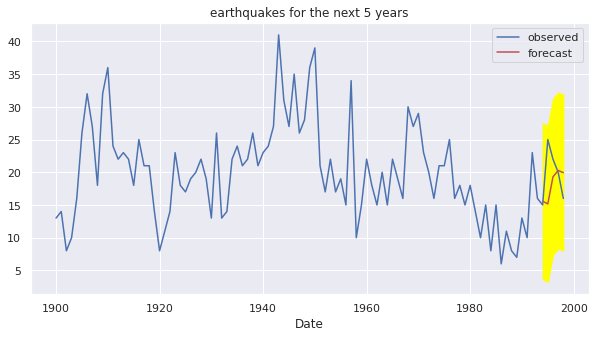

In [11]:
plt.plot(earthquake.index, earthquake['earthquakes_per_year'], label='observed')
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='yellow')
plt.xlabel('Date')
plt.title('earthquakes for the next 5 years')
plt.legend()